In [1]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
# ! pip install scikit-learn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from video import main_process_video, slow_down_video, create_video_with_ellipse_overlay
from prep_data import get_hula_hoop_coord, prep_for_lstm, save_csv
from model import HulaHoopLSTM

/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


## Set up Paths

In [2]:
user_dir = os.path.expanduser('~')
working_dir = os.path.join(user_dir, 'hulahoop_output')
os.makedirs(working_dir, exist_ok=True)

video_id = 'DSC_7450'
input_video_file = os.path.join(working_dir, f'{video_id}.MOV')

## Read and Process the Video

In [3]:
slow_factor = 4
start_frame = 150
max_frames = 3000
output_rawdata_path = os.path.join(working_dir, f'{video_id}_raw_data.pkl')


In [3]:

main_process_video(input_video_path=input_video_file, 
                   output_data_path=output_rawdata_path, 
                   output_video_path=None, 
                   start_frame=start_frame, 
                   max_frames=max_frames,
                   slow_factor=slow_factor)

### Create a video snippet


In [4]:
play_start_frame = 2100
play_max_frames = 400

output_video_path = os.path.join(working_dir, f'{video_id}_{start_frame}_processed.mp4')


In [5]:
main_process_video(input_video_path=input_video_file, 
                   output_data_path=None, 
                   output_video_path=output_video_path, 
                   start_frame=play_start_frame, 
                   max_frames=play_max_frames,
                   slow_factor=slow_factor)

In [6]:
slow_down_video(video_path=input_video_file,
                output_path=os.path.join(working_dir, f'{video_id}_{start_frame}_slowdown.mp4'),
                slow_factor=slow_factor,
                start_frame=play_start_frame,
                max_frames=play_max_frames)

'/Users/jonaheaton/hulahoop_output/DSC_7450_150_slowdown.mp4'

## Convert raw output data into a csv of coordinates of the ellipses

In [5]:
ellipse_data_path = os.path.join(working_dir, f'{video_id}_ellipse_data.csv')

hulahoop_ellipse_df = get_hula_hoop_coord(output_rawdata_path)
save_csv(hulahoop_ellipse_df, ellipse_data_path)

## Load the csv file and train an LSTM model

In [6]:
train_frac = 0.7
lookback_window = 5

In [7]:
data = pd.read_csv(ellipse_data_path)
# train_dict, test_dict, scaler = prep_for_lstm(data, train_frac=train_frac, lookback_window=lookback_window, yes_plot=True, output_dir=working_dir)
train_dict, test_dict, scaler = prep_for_lstm(data, train_frac=train_frac, lookback_window=lookback_window, yes_plot=False, output_dir=working_dir)

top ellipse X                0
top ellipse Y                0
bottom ellipse X             0
bottom ellipse Y             0
top ellipse Major Axis       3
top ellipse Minor Axis       0
bottom ellipse Major Axis    0
bottom ellipse Minor Axis    0
top ellipse Angle            3
bottom ellipse Angle         0
dtype: int64


In [11]:
print('Training Data')
print(train_dict['X'].shape)
print(train_dict['y'].shape)
print(train_dict['frames'].shape)
print('Testing Data')
print(test_dict['X'].shape)
print(test_dict['y'].shape)
print(test_dict['frames'].shape)

Training Data
(2087, 5, 10)
(2087, 10)
(2087,)
Testing Data
(895, 5, 10)
(895, 10)
(895,)


In [12]:
# create the model and fit
model = HulaHoopLSTM(input_size=10, hidden_size=64, output_size=10, num_layers=3, data_scaler=MinMaxScaler())


In [13]:
X_train = train_dict['X']
y_train = train_dict['y']
frame_train = train_dict['frames']
X_test = test_dict['X']
y_test = test_dict['y']
cols = test_dict['col names']
frame_test = test_dict['frames']

In [14]:
model.fit(X_train, y_train, num_epoch=100, batch_size=64)

Epoch 0:	 loss=0.1541
Epoch 10:	 loss=0.0024
Epoch 20:	 loss=0.0018
Epoch 30:	 loss=0.0014
Epoch 40:	 loss=0.0011
Epoch 50:	 loss=0.0010
Epoch 60:	 loss=0.0009
Epoch 70:	 loss=0.0009
Epoch 80:	 loss=0.0009
Epoch 90:	 loss=0.0008


In [15]:
model.evaluate(X_test, y_test, cols)

/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/jonaheaton/Documents/GitHub/hula_hoop/.conda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


{'top ellipse X': 7.24113130569458,
 'top ellipse X_scaled': 0.000108883083157707,
 'top ellipse Y': 2.431668519973755,
 'top ellipse Y_scaled': 0.00011015280324500054,
 'bottom ellipse X': 2.8204264640808105,
 'bottom ellipse X_scaled': 9.296270582126454e-05,
 'bottom ellipse Y': 3.2678651809692383,
 'bottom ellipse Y_scaled': 0.00011356089817127213,
 'top ellipse Major Axis': 3.6965138912200928,
 'top ellipse Major Axis_scaled': 0.0003064603661186993,
 'top ellipse Minor Axis': 4.230340480804443,
 'top ellipse Minor Axis_scaled': 0.00021476981055457145,
 'bottom ellipse Major Axis': 1.230151891708374,
 'bottom ellipse Major Axis_scaled': 0.0007367470534518361,
 'bottom ellipse Minor Axis': 0.9357483983039856,
 'bottom ellipse Minor Axis_scaled': 0.0004269031051080674,
 'top ellipse Angle': 0.3561367988586426,
 'top ellipse Angle_scaled': 0.001084027928300202,
 'bottom ellipse Angle': 126.67938232421875,
 'bottom ellipse Angle_scaled': 0.004100950434803963,
 'total': 0.000729541759938

In [16]:
y_pred = model.predict(X_test)


### Generative predictions, predict the next XX frames from the just 5 frames. 

In [17]:
num_steps = frame_test[-1] - frame_train[-1]
print(num_steps)
y_new = model.generate(X_train[-1,:,:], num_steps)

900


In [18]:
y_train

array([[301.97146606, 500.10421753, 313.73898315, ..., 165.90298462,
         82.67212677, 139.79180908],
       [350.44143677, 493.18008423, 348.19973755, ..., 161.1191864 ,
         87.96343231, 137.84649658],
       [402.48352051, 492.74478149, 385.46170044, ..., 162.70924377,
         93.43064117,  67.45027161],
       ...,
       [255.8278656 , 545.04907227, 285.47589111, ..., 190.06921387,
         86.64559937, 110.14867401],
       [249.75379944, 519.46710205, 278.49514771, ..., 175.74751282,
         85.88119507, 121.28447723],
       [287.4234314 , 500.93426514, 302.06887817, ..., 164.53720093,
         86.80496979, 124.0710144 ]])

In [29]:
df_ellipse_train = pd.DataFrame(data=y_train, columns=cols, index=frame_train)
df_ellipse_train['kind'] = 'Training'
df_ellipse_test = pd.DataFrame(data=y_test, columns=cols, index=frame_test)
df_ellipse_test['kind'] = 'Actual'
df_ellipse_pred = pd.DataFrame(data=y_pred, columns=cols, index=frame_test)
df_ellipse_pred['kind'] = 'Next Frame Prediction'
df_ellipse_new = pd.DataFrame(data=y_new, columns=cols, index = np.arange(frame_train[-1], frame_train[-1]+num_steps))

# drop the first row since it is duplicate of the training
df_ellipse_new = df_ellipse_new.iloc[1:]
df_ellipse_new['kind'] = 'Generative'


df_ellipse = pd.concat([df_ellipse_train, df_ellipse_pred])
df_ellipse.to_csv(os.path.join(working_dir, f'{video_id}_ellipse_data_nextframe_predictions.csv'))

# df_ellipse = pd.concat([df_ellipse_train, df_ellipse_test, df_ellipse_pred, df_ellipse_new])
df_ellipse = pd.concat([df_ellipse_train, df_ellipse_new])
df_ellipse.to_csv(os.path.join(working_dir, f'{video_id}_ellipse_data_generative_predictions.csv'))


df_all = pd.concat([df_ellipse_train, df_ellipse_test, df_ellipse_pred, df_ellipse_new])

## Create video with overlay of the predicted ellipses

In [28]:
create_video_with_ellipse_overlay(
    input_video_path=input_video_file,
    csv_path=os.path.join(working_dir, f'{video_id}_ellipse_data_generative_predictions.csv'),
    output_video_path=os.path.join(working_dir, f'{video_id}_ellipse_generative_overlay.mp4'),
    slow_factor=slow_factor,
    start_frame=play_start_frame,
    max_frames=play_max_frames
)

In [23]:
create_video_with_ellipse_overlay(
    input_video_path=input_video_file,
    csv_path=os.path.join(working_dir, f'{video_id}_ellipse_data_nextframe_predictions.csv'),
    output_video_path=os.path.join(working_dir, f'{video_id}_ellipse_predictions_overlay.mp4'),
    slow_factor=slow_factor,
    start_frame=play_start_frame,
    max_frames=play_max_frames
)

### plot the difference between the predicted and actual ellipses

In [31]:
# ! pip install seaborn
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.4 MB/s eta 0:00:00a 0:00:01


In [52]:
df_all['frame'] = df_all.index
hulahoop_ellipse_df.index = hulahoop_ellipse_df['frame']


scaler = MinMaxScaler()
measure_cols = [col for col in hulahoop_ellipse_df.columns if 'frame' not in col]
scaler.fit(hulahoop_ellipse_df[measure_cols])

df_sc_all = df_all.copy()
df_sc_org = hulahoop_ellipse_df.copy()


df_sc_all[measure_cols] = scaler.transform(df_sc_all[measure_cols])
df_sc_org[measure_cols] = scaler.transform(df_sc_org[measure_cols])
df_diff = df_sc_all.copy()
df_diff[measure_cols] = df_sc_all[measure_cols] - df_sc_org.loc[df_sc_all.index,measure_cols]

for col in measure_cols:
    df_diff['abs ' + col] = np.abs(df_diff[col])

In [51]:
df_diff

,top ellipse X,top ellipse Y,bottom ellipse X,bottom ellipse Y,top ellipse Major Axis,top ellipse Minor Axis,bottom ellipse Major Axis,bottom ellipse Minor Axis,top ellipse Angle,bottom ellipse Angle,kind,frame
155,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Training,155
156,0.000000e+00,0.000000,0.000000,1.110223e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Training,156
157,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Training,157
158,2.220446e-16,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Training,158
159,2.220446e-16,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Training,159
...,...,...,...,...,...,...,...,...,...,...,...,...
3144,-3.993055e-01,-0.045893,-0.431946,-1.163149e-01,-0.004239,-0.027523,-0.127143,-0.090494,-0.027464,0.414942,Generative,3144
3145,-3.113767e-01,-0.114446,-0.300986,-3.455599e-01,-0.050618,-0.073023,-0.248177,-0.332275,-0.015405,0.093199,Generative,3145
3146,-9.361427e-02,-0.157589,-0.051615,-4.767770e-01,-0.104330,-0.131098,-0.387140,-0.463304,-0.000484,-0.021422,Generative,3146
3147,2.289372e-01,-0.159385,0.269315,-4.391259e-01,-0.112598,-0.173489,-0.401421,-0.410093,0.020110,-0.106876,Generative,3147


top ellipse X
0.045921927565567566
first generative frame: 2250
number of frames before generative model diverges: 15


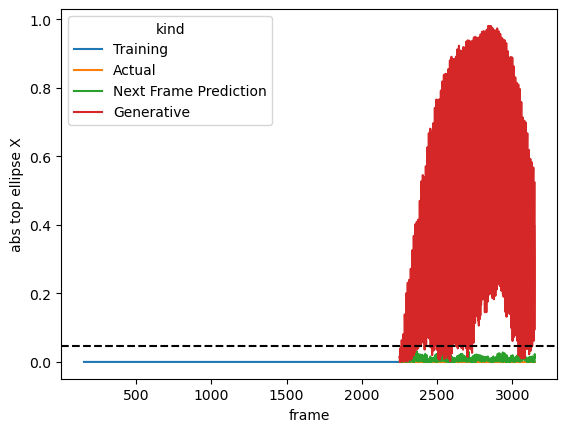

In [59]:
# df_diff['abs top ellipse X diff'] = np.abs(df_diff['top ellipse X'])
# scale 
col_name = 'top ellipse X'
print(col_name)

sns.lineplot(data=df_diff, x='frame', y=f'abs {col_name}', hue='kind')

max_abs_err_next_frame = df_diff[df_diff['kind'] == 'Next Frame Prediction'][f'abs {col_name}'].max()
print(max_abs_err_next_frame)
plt.axhline(max_abs_err_next_frame, color='k', linestyle='--', label=f'Max Abs Error Next Frame: {max_abs_err_next_frame:.2f}')

# which frame does the generative error exceed the next frame error
frame_exceed = df_diff[df_diff['kind'] == 'Generative'][f'abs {col_name}'] > max_abs_err_next_frame
frame_exceed = frame_exceed[frame_exceed].index[0]
first_generative_frame = df_diff[df_diff['kind'] == 'Generative'].index[0]
print('first generative frame:', first_generative_frame)
print('number of frames before generative model diverges:', frame_exceed - first_generative_frame)